Given a new purchase order, what is the predicted actual lead time?

In [93]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from IPython.display import display

DATA_PATH = Path().cwd().parent / "data"

def read_data(file_name):
    return pd.read_csv(DATA_PATH / file_name, parse_dates=True)

ship_df = read_data("shipments.csv")
purchase_df = read_data("purchase_orders.csv")
suppliers_df = read_data("suppliers.csv")
sku_df = read_data("skus.csv")
transit_events_df = read_data("transit_events.csv")
sites_df = read_data("sites.csv")
deployments_df = read_data("deployments.csv")
rma_returns_df = read_data("rma_returns.csv")
inventory_df = read_data("inventory_snapshots.csv")

KeyboardInterrupt: 

In [ ]:
ship_df


,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status
0,SH-00000001,PO-0104861,6,Road,CIF,Mexico,ST-00452,2025-02-03,2025-02-10,Delivered
1,SH-00000002,PO-0099598,3,Sea,EXW,India,ST-00086,2024-08-21,2024-09-27,Delayed
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit
3,SH-00000004,PO-0047627,6,Sea,FOB,Argentina,ST-00800,2023-07-03,2023-08-05,In Transit
4,SH-00000005,PO-0003236,6,Road,DAP,Brazil,ST-01995,2025-06-19,2025-06-27,Delivered
...,...,...,...,...,...,...,...,...,...,...
217495,SH-00217496,PO-0033886,2,Road,EXW,Argentina,ST-01757,2023-09-30,2023-10-07,In Transit
217496,SH-00217497,PO-0038120,7,Road,EXW,Mexico,ST-01876,2024-08-14,2024-08-27,Delivered
217497,SH-00217498,PO-0079713,3,Air,DAP,Spain,ST-01330,2023-12-25,2024-01-02,In Transit
217498,SH-00217499,PO-0044911,4,Air,FOB,Brazil,ST-01986,2025-02-24,2025-03-05,Delivered


Text(0.5, 1.0, 'Transit Event Status Distribution (Top 10)')

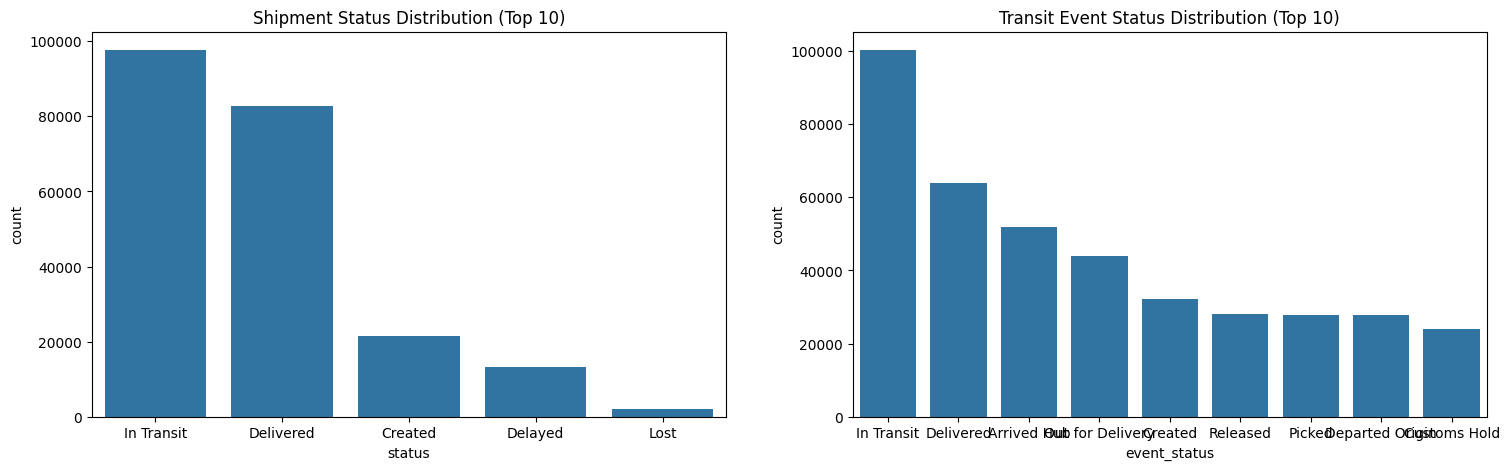

In [ ]:
# Basic distributions to understand shipment and event statuses
status_summary = ship_df.groupby("status").size().reset_index(name='count').sort_values("count", ascending=False)
event_status_summary = transit_events_df.groupby("event_status").size().reset_index(name='count').sort_values("count", ascending=False)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=status_summary.head(10), x="status", y="count")
plt.title("Shipment Status Distribution (Top 10)")
plt.subplot(1, 2, 2)
sns.barplot(data=event_status_summary.head(10), x="event_status", y="count")
plt.title("Transit Event Status Distribution (Top 10)")

In [ ]:
# Summaries of delivered shipments and latest in-flight events
actual_delivery = (
    transit_events_df[
        (transit_events_df["event_status"] == "Delivered")
        & transit_events_df["event_ts"].notna()
        & (transit_events_df["location_type"] == "Destination")
    ]
    .groupby("shipment_id")
    .agg(actual_delivery_ts=("event_ts", "max"))
    .reset_index()
)

# lets assume that the latest event for each shipment is the current status
latest_event = (
    transit_events_df
    .sort_values("event_ts")
    .groupby("shipment_id")
    .agg(
        last_event_ts=("event_ts", "max"),
        last_event_status=("event_status", "last")
    )
    .reset_index()
)

# from len transit events only n is actually usefull
print(f'from {len(transit_events_df)} transit events, only {len(actual_delivery)} are useful for actual delivery times.')

from 400000 transit events, only 6967 are useful for actual delivery times.


In [ ]:
# Step 2: combine shipment facts with purchase-order context
shipments_enriched = (
    ship_df
    .merge(latest_event, on="shipment_id", how="left")
    .merge(actual_delivery, on="shipment_id", how="left")
    .merge(
        purchase_df[["po_id", "order_date", "promised_date", "supplier_id", "order_qty", "status"]],
        on="po_id",
        how="left",
        suffixes=("", "_right")
    )
)
# last_event_status actual_delivery_ts last_event_ts are often null for in-flight shipments
# because not all shipments have events yet

shipments_enriched

,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,last_event_ts,last_event_status,actual_delivery_ts,order_date,promised_date,supplier_id,order_qty,status_right
0,SH-00000001,PO-0104861,6,Road,CIF,Mexico,ST-00452,2025-02-03,2025-02-10,Delivered,NaN,NaN,NaN,2024-05-25,2024-06-24,S-0025,7,Closed
1,SH-00000002,PO-0099598,3,Sea,EXW,India,ST-00086,2024-08-21,2024-09-27,Delayed,2024-03-09 04:00:00,Out for Delivery,NaN,2024-12-11,2024-12-29,S-0002,11,Closed
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit,2023-02-27 07:00:00,In Transit,NaN,2024-04-28,2024-05-14,S-0178,12,Closed
3,SH-00000004,PO-0047627,6,Sea,FOB,Argentina,ST-00800,2023-07-03,2023-08-05,In Transit,2025-09-02 20:00:00,Delivered,NaN,2024-10-27,2024-12-01,S-0091,13,Closed
4,SH-00000005,PO-0003236,6,Road,DAP,Brazil,ST-01995,2025-06-19,2025-06-27,Delivered,NaN,NaN,NaN,2023-04-01,2023-04-27,S-0036,11,Closed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217495,SH-00217496,PO-0033886,2,Road,EXW,Argentina,ST-01757,2023-09-30,2023-10-07,In Transit,NaN,NaN,NaN,2024-02-25,2024-03-23,S-0200,11,Closed
217496,SH-00217497,PO-0038120,7,Road,EXW,Mexico,ST-01876,2024-08-14,2024-08-27,Delivered,2023-07-30 22:00:00,Arrived Hub,NaN,2023-02-12,2023-03-08,S-0112,8,Closed
217497,SH-00217498,PO-0079713,3,Air,DAP,Spain,ST-01330,2023-12-25,2024-01-02,In Transit,2023-09-12 05:00:00,Arrived Hub,NaN,2025-05-17,2025-06-29,S-0067,7,Closed
217498,SH-00217499,PO-0044911,4,Air,FOB,Brazil,ST-01986,2025-02-24,2025-03-05,Delivered,NaN,NaN,NaN,2024-02-29,2024-03-30,S-0050,6,Open


In [ ]:
# how much from shippements.status = Delivered are the transit_events.event_status = Delivered & locatio_type = 'Destination'
delivered_shipments = shipments_enriched[shipments_enriched["status"] == "Delivered"]
delivered_with_events = delivered_shipments[delivered_shipments["actual_delivery_ts"].notna()]

print(f'Out of {len(delivered_shipments)} shipments with status Delivered, only {len(delivered_with_events)} have actual delivery events recorded at Destination location.')

Out of 82824 shipments with status Delivered, only 2664 have actual delivery events recorded at Destination location.


Number of shipments with order_date > ship_date:  108981 normal shipments:  108519
 108981 normal shipments:  108519


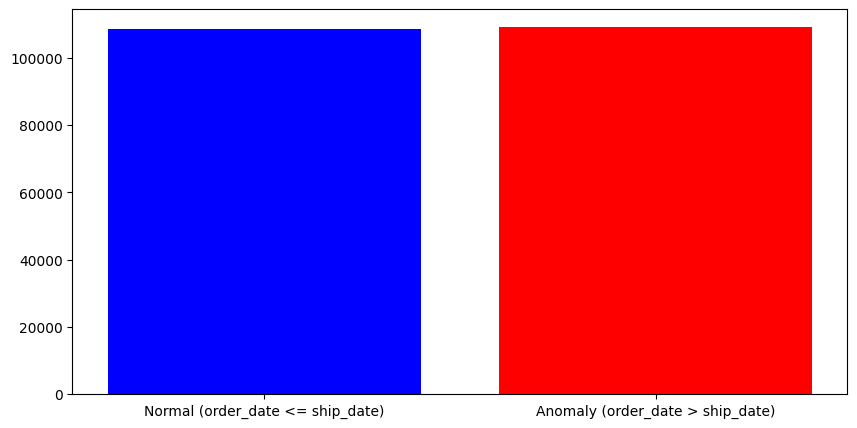

In [ ]:
# show order_date > ship_date annomalies

plt.figure(figsize=(10, 5))
# normal count wrong count
plt.bar(
    ["Normal (order_date <= ship_date)", "Anomaly (order_date > ship_date)"],
    [
        len(shipments_enriched[shipments_enriched["order_date"] <= shipments_enriched["ship_date"]]),
        len(shipments_enriched[shipments_enriched["order_date"] > shipments_enriched["ship_date"]]),
    ],
    color=["blue", "red"]
)
print(
    "Number of shipments with order_date > ship_date: ",
    len(shipments_enriched[shipments_enriched["order_date"] > shipments_enriched["ship_date"]]),
    "normal shipments: ",
    len(shipments_enriched[shipments_enriched["order_date"] <= shipments_enriched["ship_date"]])
)

In [ ]:
# lets assume half of data is wrong and work only with the rest
clean_shipments = shipments_enriched[shipments_enriched["order_date"] <= shipments_enriched["ship_date"]]
print(" Valid shipments count: ", len(clean_shipments))
clean_shipments = clean_shipments[clean_shipments["actual_delivery_ts"].notna()]
print("Shipments with actual delivery timestamp count: ", len(clean_shipments))
# also let us only get shipments that were fully shipped (`po.order_qty` == sum of `ship.ship_qty`)
total_shipped = ship_df.groupby("po_id")["ship_qty"].sum().reset_index(name="total_shipped_qty")
clean_shipments = clean_shipments.merge(total_shipped, on="po_id", how="inner")
clean_shipments = clean_shipments[clean_shipments["order_qty"] == clean_shipments["total_shipped_qty"]]
print("Fully shipped clean shipments count: ", len(clean_shipments))

 Valid shipments count:  108519
Shipments with actual delivery timestamp count:  3471
Fully shipped clean shipments count:  205
Fully shipped clean shipments count:  205


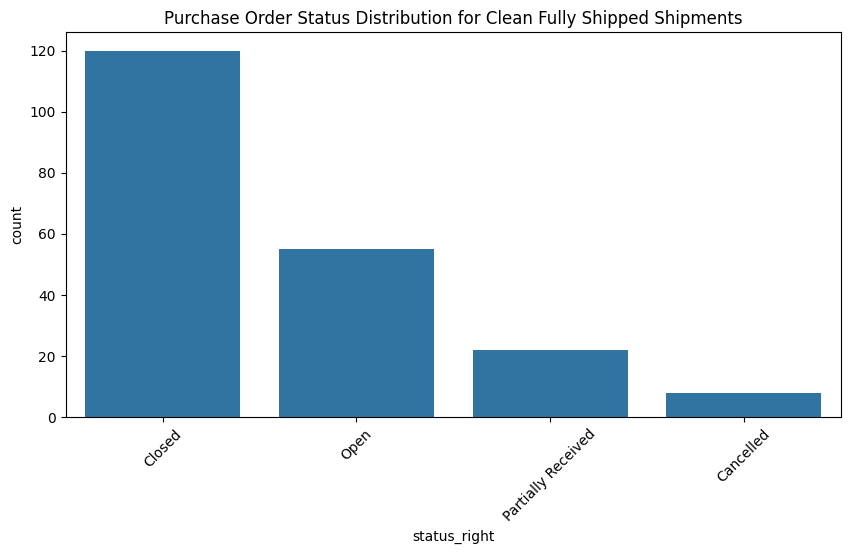

In [ ]:
# let's check how does it align with po.status (should be `Closed`)
# plot pucharse_order.status
data = clean_shipments.groupby("status_right").size().reset_index(name='count').sort_values("count", ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(data=data, x="status_right", y="count")
plt.title("Purchase Order Status Distribution for Clean Fully Shipped Shipments")
plt.xticks(rotation=45)
plt.show()
# HOW? I just don't get it. Are those statuses not updated? Because they were FULLY RECEIVED...

# To SUM UP.

- **Cell 5:** Only 6,967 of the 400,000 transit events correspond to "Delivered" scans at the destination, so barely ~1.7% of the raw telemetry is usable for ground-truth delivery timestamps.
- **Cell 7:** Even among the 82,824 shipments flagged as Delivered, just 2,664 (≈3.2%) actually have those destination delivery events, which means the shipment.status flag cannot be trusted as proof of receipt.
- **Cell 8:** Order timestamps are corrupt for roughly half of the records (108,981 cases where `order_date > ship_date` versus 108,519 valid rows), so the timeline fields coming from purchase orders are unreliable without heavy filtering.
- **Cell 9:** After removing the obvious timestamp errors and requiring a recorded delivery plus full PO fulfillment, the cohort shrinks from 108,519 "valid" shipments to only 205—data that small can’t support robust modeling and is likely biased toward the cleanest cases.
- **Cell 10:** Those fully received shipments still span multiple PO statuses instead of being uniformly `Closed`, so upstream PO lifecycle tracking is out of sync with the shipment reality.

In [ ]:
# order_date → promised_date → ship_date → eta_date → actual_delivery_ts
#    (PO)         (supplier)      (actual)   (estimate)    (ground truth)

clean_shipments["actual_delay"] = (
    pd.to_datetime(clean_shipments["actual_delivery_ts"]) - pd.to_datetime(clean_shipments["promised_date"])
).dt.days 
#  negative delays = 0
clean_shipments.loc[clean_shipments["actual_delay"] < 0, "actual_delay"] = 0

clean_shipments

C:\Users\miskibin\AppData\Local\Temp\ipykernel_26308\3273329063.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_shipments["actual_delay"] = (


,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,last_event_ts,last_event_status,actual_delivery_ts,order_date,promised_date,supplier_id,order_qty,status_right,total_shipped_qty,actual_delay
25,SH-00001479,PO-0105068,6,Sea,EXW,Spain,ST-01111,2024-06-02,2024-07-13,In Transit,2025-02-08 18:00:00,Out for Delivery,2023-11-15 01:00:00,2023-10-01,2023-10-26,S-0124,12,Closed,12,20
35,SH-00002012,PO-0010932,6,Air,DAP,Australia,ST-00403,2025-09-08,2025-09-13,Delivered,2024-04-07 09:00:00,In Transit,2024-01-03 20:00:00,2023-09-30,2023-11-21,S-0103,9,Closed,9,43
49,SH-00002934,PO-0109220,3,Air,EXW,Indonesia,ST-00504,2024-05-10,2024-05-21,In Transit,2025-09-11 01:00:00,Delivered,2025-09-11 01:00:00,2023-05-20,2023-06-05,S-0194,13,Closed,13,829
55,SH-00003409,PO-0101359,4,Road,DAP,Thailand,ST-00562,2024-04-11,2024-04-22,In Transit,2025-01-14 16:00:00,Delivered,2025-01-14 16:00:00,2023-11-14,2023-12-15,S-0123,8,Closed,8,396
61,SH-00003615,PO-0084821,3,Road,DDP,Spain,ST-00864,2025-08-09,2025-08-16,Delivered,2025-08-28 03:00:00,Delivered,2025-08-28 03:00:00,2024-10-18,2024-11-23,S-0076,12,Closed,12,278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399,SH-00212717,PO-0116470,5,Road,DAP,Colombia,ST-00825,2024-07-29,2024-08-05,Delivered,2025-05-08 22:00:00,In Transit,2025-03-31 17:00:00,2023-06-10,2023-07-08,S-0160,8,Closed,8,632
3447,SH-00215483,PO-0003940,3,Air,FOB,UK,ST-01218,2024-12-29,2025-01-06,In Transit,2025-06-14 05:00:00,Delivered,2025-06-14 05:00:00,2023-08-29,2023-10-02,S-0111,13,Open,13,621
3457,SH-00216644,PO-0111636,4,Rail,DAP,Argentina,ST-00226,2023-09-20,2023-10-02,In Transit,2025-07-18 23:00:00,Arrived Hub,2024-07-10 01:00:00,2023-01-27,2023-03-03,S-0098,11,Closed,11,495
3465,SH-00217055,PO-0081333,4,Road,CIF,Canada,ST-01077,2023-12-12,2023-12-22,In Transit,2025-01-17 06:00:00,Out for Delivery,2024-04-28 06:00:00,2023-07-20,2023-09-01,S-0171,11,Open,11,240


Text(0, 0.5, 'Frequency')

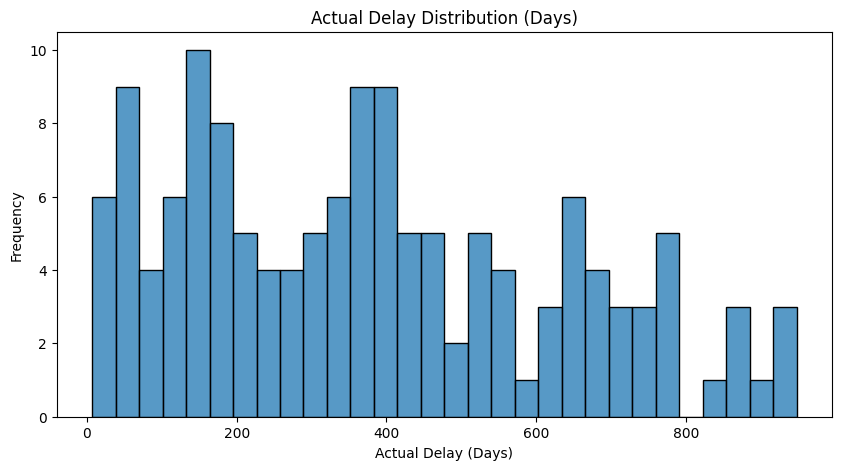

In [95]:
# plot actual_delay distribution
plt.figure(figsize=(10, 5))
sns.histplot(clean_shipments["actual_delay"], bins=30, kde=False)
plt.title("Actual Delay Distribution (Days)")
plt.xlabel("Actual Delay (Days)")
plt.ylabel("Frequency")


C:\Users\miskibin\AppData\Local\Temp\ipykernel_26308\3698084376.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_shipments[feature + "_encoded"] = clean_shipments[feature].astype('category').cat.codes
C:\Users\miskibin\AppData\Local\Temp\ipykernel_26308\3698084376.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_shipments[feature + "_encoded"] = clean_shipments[feature].astype('category').cat.codes
C:\Users\miskibin\AppData\Local\Temp\ipykernel_26308\3698084376.py:4: SettingWithCopyWarning

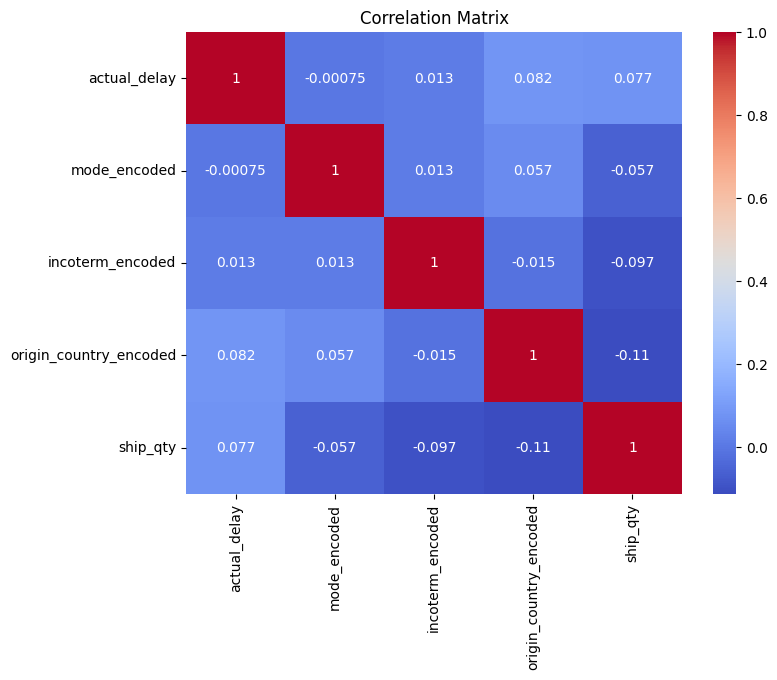

In [99]:
# correlate actual_delay with ship_qty mode (encode), incoterm (encode), mode  origin_country (enccoded)
categorical_features = ["mode", "incoterm", "origin_country"]
for feature in categorical_features:
    clean_shipments[feature + "_encoded"] = clean_shipments[feature].astype('category').cat.codes


# correlation matrix with ship_qty mode_encoded, incoterm_encoded, origin_country_encoded vs actual_delay

corr_matrix = clean_shipments[["actual_delay"] + [f + "_encoded" for f in categorical_features ] + ["ship_qty"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [101]:
from scipy.stats import spearmanr

rho, p = spearmanr(clean_shipments["ship_qty"], clean_shipments["actual_delay"])
print("Spearman correlation:", rho)
print("p-value:", p)

Spearman correlation: 0.04138821546861443
p-value: 0.6285556053249595
